# ディープラーニング

## ディープな手書き数字認識

- 3x3の小さなフィルターによる畳込み層
- 活性化関数はReLU
- 全結合層の後にDropoutレイヤを使用
- Adamによる最適化
- 重みの初期値として「Heの初期値」を使用

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *


class DeepConvNet:
    """認識率99%以上の高精度なConvNet

    ネットワーク構成は下記の通り
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 重みの初期化===========
        # 各層のニューロンひとつあたりが、前層のニューロンといくつのつながりがあるか（TODO:自動で計算する）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLUを使う場合に推奨される初期値
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # レイヤの生成===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]

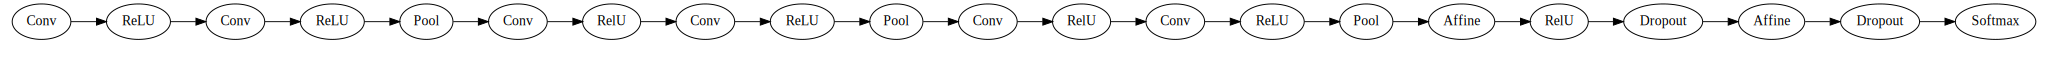

In [5]:
from graphviz import Digraph
dot = Digraph(comment="上記ディープラーニングのグラフ")
dot.attr(rankdir="LR")
#dot.attr(splines="") #line or curved or ortho or polyline;
dot.attr(fixedsize="true")
dot.attr(label="上記ディープラーニングのグラフ")
with dot.subgraph(name="main") as main:
    main.node("L1","Conv")
    main.node("L2","ReLU")
    main.node("L3","Conv")
    main.node("L4","ReLU")
    main.node("L5","Pool")
    main.node("L6","Conv")
    main.node("L7","RelU")
    main.node("L8","Conv")
    main.node("L9","ReLU")
    main.node("L10","Pool")
    main.node("L11","Conv")
    main.node("L12","RelU")
    main.node("L13","Conv")
    main.node("L14","ReLU")
    main.node("L15","Pool")
    main.node("L16","Affine")
    main.node("L17","RelU")
    main.node("L18","Dropout")
    main.node("L19","Affine")
    main.node("L20","Dropout")
    main.node("L21","Softmax")
    main.edge("L1", "L2",label="")
    main.edge("L2", "L3",label="")
    main.edge("L3", "L4",label="")
    main.edge("L4", "L5",label="")
    main.edge("L5", "L6",label="")
    main.edge("L6", "L7",label="")
    main.edge("L7", "L8",label="")
    main.edge("L8", "L9",label="")
    main.edge("L9", "L10",label="")
    main.edge("L10", "L11",label="")
    main.edge("L11", "L12",label="")
    main.edge("L12", "L13",label="")
    main.edge("L13", "L14",label="")
    main.edge("L14", "L15",label="")
    main.edge("L15", "L16",label="")
    main.edge("L16", "L17",label="")
    main.edge("L17", "L18",label="")
    main.edge("L18", "L19",label="")
    main.edge("L19", "L20",label="")
    main.edge("L20", "L21",label="")
    #print(dot)
dot

### このCNNの認識精度は概ね99%を超す

## さらに認識精度を高めるには

- アンサンブル学習(ensemble learning)
- 学習系率の減衰(learning rate decay)
- データ拡張(data aughmentation)

### Data Augmentation

入力画像を人工的なアルゴリズムによって微小変化させる
- Crop処理: データを切り出す
- flip処理: データを回線させる
- scale処理: データを拡大縮小させる

## 層を深くすることのモチベーション

層をいたずらに深くする事の重要性は証明されていないが、昨今の傾向としては層を深くする（認識性能の向上を見込んでいる）方向に向かっている。
層を深くすることの利点
- 層を深くしない場合に比べより少ないパラメータで同レベル以上の表現をすることが出来る
- 特に小さなフィルターを重ねてネットワークを深くすることにより受容野（receptive field）を広くすることが出来る。
- 層を重ねることでReLU等の活性化関数が畳み込み層の間に挟まれることになり、非線形の力を強める事ができる。
- 各層が別の特徴を捉えることでCNN全体が一つの特徴以外に囚われなくなる
    - 各層が学習すべき課題がよりシンプルな問題へと分解される

## ディープラーニングの少歴史

ILSVRC(ImageNet Large Scale Visual Recognition Challenge)でAlexNetが圧倒的成績で優勝したことがブームの始まり

### ImageNet

[ILSVRC(ImageNet Large Scale Visual Recognition Challenge)](http://www.image-net.org/challenges/LSVRC/)は画像認識のコンペティション。  
その中でもVGG, GoogleLeNet, RasNetが有名。

### VGG

https://www.researchgate.net/figure/A-visualization-of-the-VGG-architecture_fig2_318701491
![https://www.researchgate.net/profile/Mhaned_Oubounyt/publication/318701491/figure/fig2/AS:520298631446528@1501060268099/A-visualization-of-the-VGG-architecture.png](https://www.researchgate.net/profile/Mhaned_Oubounyt/publication/318701491/figure/fig2/AS:520298631446528@1501060268099/A-visualization-of-the-VGG-architecture.png)

VGGは非常にシンプル。3x3フィルタの畳み込み層を連続させ、プーリング層でサイズを半分にする。最後に全結合層を経由して出力。

### GoogLeNet

https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/googlenet.html
![https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_5/GoogleNet.png](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_5/GoogleNet.png)

インセプション構造を1x1のフィルタによる畳み込み層で挟むことでパラメータの削減・処理の高速化をしている

### ResNet

層を深くしすぎると勾配減衰が発生し、最終的な性能が劣るという問題をクリアするために、「スキップ構造」を使っている。
スキップ構造であ伝搬時も逆伝搬時も入力データをそのまま流すので、勾配の変化がゆるやかになる。

https://www.safaribooksonline.com/library/view/practical-computer-vision/9781788297684/12a933e6-e3c6-47d5-9064-512c8a0b4667.xhtml
![https://www.safaribooksonline.com/library/view/practical-computer-vision/9781788297684/assets/1e122e62-bd2e-4b66-be3f-1a11c5028ec9.png](https://www.safaribooksonline.com/library/view/practical-computer-vision/9781788297684/assets/1e122e62-bd2e-4b66-be3f-1a11c5028ec9.png)

ResNetはVGGにスキップ構造を足したもの。  
http://alimurreza.blogspot.com/2017/04/deep-residual-network-resnet.html  
![https://2.bp.blogspot.com/-J7j0eUkNJ-w/WPU7iXKs6II/AAAAAAAAJt0/FMY6pOVMu34y2TziHnVPbadohKim1XpKACLcB/s640/resnet_vs_plainnet.png](https://2.bp.blogspot.com/-J7j0eUkNJ-w/WPU7iXKs6II/AAAAAAAAJt0/FMY6pOVMu34y2TziHnVPbadohKim1XpKACLcB/s640/resnet_vs_plainnet.png)

#### 転移学習
VGGなど既存のネットワーク構成をそのまま引き継ぐことで学習済みの重みを初期値として新しいデータセットを対象に再学習を行うことを「転移学習」と呼ぶ。手元にあるデータがスクアに場合において転移学習は有効な手法である。

## ディープラーニングの高速化

ディープラーニングフレームワークの多くはGPU処理をサポートしているが、最近では複数のGPUや複数の筐体での分散学習にも対応してきている。

### 取り組むべき課題

https://www2.eecs.berkeley.edu/Pubs/TechRpts/2014/EECS-2014-93.pdf  
畳み込み層の処理が最も計算容量が大きい為、学習時・推論時の両方の観点でいかに畳み込み層の計算量を減らすかがカギとなる。
ここで言う畳み込み層の処理とは、元をたどれば大量の積和演算であり、最終的には積和演算をいかに拘束に効率的に処理するかということに行き着く。

#### GPUによる高速化

NVIDIAが提供するCUDA開発環境を使ってGPUコンピューティングすることができる。特にim2colのように大きな塊を一気に計算できる形式に変換できる関数と相性が良い。

#### 分散学習による高速化

TensorFlowのような分散学習の機能が入ったライブラリを使用すること

#### 演算精度のビット削減

演算精度のビットを削減しても、そこまで演算結果に影響が無いことが分かっている。一般的に16ビットの半精度浮動小数点数でディープラーニングを行うことができることが分かっている。

### ディープラーニングの実用例

#### 物体検出

https://www.quora.com/Where-can-I-find-a-nice-tutorial-for-Regional-based-Convolution-neural-Network
![https://qph.fs.quoracdn.net/main-qimg-c96241e4e90c2b8509c4b1e87965965a.webp](https://qph.fs.quoracdn.net/main-qimg-c96241e4e90c2b8509c4b1e87965965a.webp)

物体検出では2.で物体らしき領域を抜き出し、3.で物体の内訳を処理するというフローとなる。  
2.についてはR-CNNではSelective Searchと呼ばれる手法で実装されているが、最近ではこれもCNNで行う手法が提案されている。

#### セグメンテーション

https://www.researchgate.net/figure/Schematic-illustration-of-a-cascaded-CNN-architecture-for-brain-tumor-segmentation-task_fig2_317341396
![https://www.researchgate.net/profile/Zeynettin_Akkus/publication/317341396/figure/fig2/AS:502178922102784@1496740193411/Schematic-illustration-of-a-cascaded-CNN-architecture-for-brain-tumor-segmentation-task.png](https://www.researchgate.net/profile/Zeynettin_Akkus/publication/317341396/figure/fig2/AS:502178922102784@1496740193411/Schematic-illustration-of-a-cascaded-CNN-architecture-for-brain-tumor-segmentation-task.png)

画像のあるエリアを矩形抽出し、推論処理をすると縦x横のピクセル分も計算が必要なため、無駄である。
そこで、計算する前に一度畳み込みによりエッジ抽出をし、全結合層でもCNNを使い逆畳み込みを実施しデータを抽象化する手法。

#### 画像キャブション生成

https://heuristic.exblog.jp/26280459/
![https://pds.exblog.jp/pds/1/201612/27/04/c0338704_11201262.jpg](https://pds.exblog.jp/pds/1/201612/27/04/c0338704_11201262.jpg)

CNNと自然言語処理を合わせたもの

## ディープラーニングの未来

### 画像スタイル変換

https://japanese.engadget.com/2015/08/31/dnn/
![https://s.aolcdn.com/hss/storage/midas/4268f75101a54385118d379aa4e6d8d3/202560222/artsconsol.jpg](https://s.aolcdn.com/hss/storage/midas/4268f75101a54385118d379aa4e6d8d3/202560222/artsconsol.jpg)

### 画像生成

https://qiita.com/sergeant-wizard/items/0a57485bc90a35efcf26
![https://camo.qiitausercontent.com/535607788a9e18ae42c12b4c3ec8747ed9495073/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f36373231372f34353939396163642d363566372d363439612d313133362d6462316632663164366465612e706e67](https://camo.qiitausercontent.com/535607788a9e18ae42c12b4c3ec8747ed9495073/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f36373231372f34353939396163642d363566372d363439612d313133362d6462316632663164366465612e706e67)

#### 自動運転

https://www.semanticscholar.org/paper/End-to-End-Learning-for-Self-Driving-Cars-Bojarski-Testa/0e3cc46583217ec81e87045a4f9ae3478a008227
![https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/0e3cc46583217ec81e87045a4f9ae3478a008227/3-Figure2-1.png](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/0e3cc46583217ec81e87045a4f9ae3478a008227/3-Figure2-1.png)

#### Deep Q-Network (強化学習)

https://www.toshiba-sol.co.jp/tech/sat/case/1804_1.htm
![https://www.toshiba-sol.co.jp/tech/sat/case/images/graph_case16_02_gr.png](https://www.toshiba-sol.co.jp/tech/sat/case/images/graph_case16_02_gr.png)

AlphaGoなど